In [2]:
import glob
import math
import numpy as np
import os
import pandas as pd

from PIL import Image
#from keras.preprocessing import image
from progressbar import ProgressBar

In [25]:
def resize_and_crop(img,target_width=224,target_height=224):
    width, height = img.size
    
    img_ratio = width / float(height)
    target_ratio = target_width / float(target_height)
    
    # 1) compare ratios and resize the larger side proportional to the target of the smaller side 
    new_width, new_height = (target_width, target_height)
    
    if target_ratio > img_ratio:
        new_height = int(round(height * (target_width / float(width))))
    else:
        new_width = int(round(width * (target_height / float(height))))

    img_new = img.resize((new_width, new_height), Image.ANTIALIAS)
    # The filter argument can be one of NEAREST (use nearest neighbour), BILINEAR (linear interpolation in a 
    # 2x2 environment), BICUBIC (cubic spline interpolation in a 4x4 environment), or ANTIALIAS (a high-quality downsampling filter).
    # If omitted, or if the image has mode "1" or "P", it is set to NEAREST.
    # Note that the bilinear and bicubic filters in the current version of PIL are not well-suited for large downsampling
    # ratios (e.g. when creating thumbnails). You should use ANTIALIAS unless speed is much more important than quality.

    # 2) crop to target size
    # offset to half of the remaining padding (one of them is 0)
    width_offset  = (new_width - target_width) / 2
    height_offset = (new_height - target_height) / 2
    
    # crop with offsets
    img_new = img_new.crop((width_offset, height_offset, width_offset+target_width, height_offset+target_height))
    #  The box is a 4-tuple defining the left, upper, right, and lower pixel coordinate.
    return img_new

In [6]:
path = 'data/CarData/TestImages'
files = glob.glob(os.path.join(path, '*.pgm'))
print "Found", len(files), "files"

Found 170 files


In [26]:
images = []
image_names = []

for filename in files:
    image_names.append(os.path.basename(filename))
    with Image.open(filename) as img:
        images.append(resize_and_crop(img,target_width=100,target_height=40))

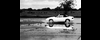

In [21]:
images[2]

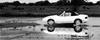

In [27]:
images[2]

In [4]:
PATH = '/data/images/monds-persondetect-7k' # base path
IMG_PATH = PATH #os.path.join(PATH, 'images')
OUT_PATH = os.path.join(PATH, 'thumbs')
target_size = (224,224)
out_file = os.path.join(OUT_PATH, "mon_style_persons_cropped_resized_%dx%d.npz" % (target_size[0], target_size[1]))

csv_file = os.path.join(PATH, 'labels.csv')

In [5]:
image_list = pd.read_csv(csv_file)

image_files = list(image_list.image)
#image_files = image_list.image.head() # temp to debug
print "Filelist contains", len(image_files), "files"

Filelist contains 7833 files


In [12]:
thumbs = []
transpose_for_keras = False
pbar = ProgressBar()

#for fil in image_files:
for fil in pbar(image_files):
    img = Image.open(os.path.join(IMG_PATH, fil))
    #print img.format, img.size, #img.info
    # or use keras.preprocessing.image.load_img (does the some, but handles also grayscale)
    
    img_new = resize_and_crop(img,target_size[0],target_size[1])
    #print img_new.size
    
    # TODO check if needed: convert opencv-image to keras format 
    # (note: for keras it depends on TF vs. Theano) -> therefore we keep the order as is and do that later
    #img_new = np.swapaxes(np.swapaxes(img_new, 1, 2), 0, 1)[[2,1,1],:,:]
    
    if transpose_for_keras:
        # acc. to Keras application tutorials:
        # convert to float32 and order height, width, channel -> channel, height, width
        # TODO we dont want to convert to float32 as it makes file size 4x as large
        img_new = image.img_to_array(img_new)
    else:
        # simply convert to numpy
        img_new = np.array(img_new)

    thumbs.append(img_new)

100% (7833 of 7833) |######################| Elapsed Time: 0:09:20 Time: 0:09:20



In [13]:
# convert list to np array
# will have shape (n_files, 224, 224, 3)

thumbs_out = np.array(thumbs)

In [14]:
# save to NPZ
np.savez(out_file, images=thumbs_out, filenames=image_files)
print "Saved to", out_file

Saved to /data/images/monds-persondetect-7k/thumbs/mon_style_persons_cropped_resized_224x224.npz


In [15]:
thumbs_out.shape

(7833, 224, 224, 3)

In [16]:
thumbs_out.dtype

dtype('uint8')